In [52]:
import numpy as np
import math
import torch
from torch import nn
from torch import functional as F
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from scipy.stats import invwishart
from Inference.Variational import MeanFieldVariationalDistribution

In [53]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Variational Distribution #

In [54]:
D = 2

In [55]:
q = MeanFieldVariationalDistribution(D, mu=-3.0, sigma=3.0)

# Posterior #

In [56]:
S = invwishart.rvs(D, np.identity(D))

In [57]:
def logposterior(x):
    return torch.distributions.multivariate_normal.MultivariateNormal(torch.ones([1,D]), covariance_matrix=torch.tensor(S).float()).log_prob(x).unsqueeze(-1)

In [58]:
import pylab as plt
import numpy as np
T = 100
# Sample data
side = np.linspace(-5,5,T)
X,Y = np.meshgrid(side,side)

In [59]:
Z = np.zeros(X.shape)
for i in range(T):
    for j in range(T):
        x = torch.tensor([X[i,j], Y[i,j]])
        Z[i,j] = torch.exp(logposterior(x))

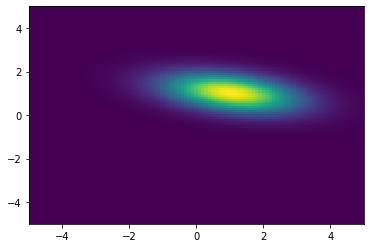

In [60]:
# Plot the density map using nearest-neighbor interpolation
plt.pcolormesh(X,Y,Z)
plt.show()

In [ ]:
Z = np.zeros(X.shape)
for i in range(T):
    for j in range(T):
        x = torch.tensor([X[i,j], Y[i,j]])
        Z[i,j] = torch.exp(logposterior(x)) + q.log_prob(x).exp()

In [ ]:
# Plot the density map using nearest-neighbor interpolation
plt.pcolormesh(X,Y,Z)
plt.show()

In [63]:
n_samples_ELBO = 100

In [64]:
optimizer = torch.optim.Adam(q.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5)

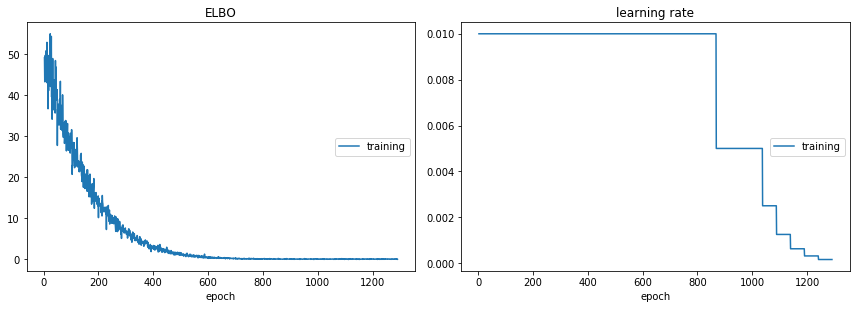

ELBO:
training   (min:   -0.033, max:   54.973, cur:    0.038)

learning rate:
training   (min:    0.000, max:    0.010, cur:    0.000)


In [65]:
%matplotlib inline
liveloss = PlotLosses()
for t in range(10000):
    logs = {}
    optimizer.zero_grad()

    z = q.sample(n_samples_ELBO)
    LQ = q.log_prob(z)
    LP = logposterior(z)
    L = (LQ - LP).sum()/n_samples_ELBO

    L.backward()
    
    learning_rate = optimizer.param_groups[0]['lr']
    
    scheduler.step(L.detach().clone().cpu().numpy())
    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    liveloss.update(logs)
    
    if t % 10 == 0:
        liveloss.draw()

    optimizer.step()
    
    if learning_rate < 0.0001:
        break